In [1]:
import warnings
warnings.filterwarnings("ignore")

import driveanon as da
import xarray as xr
import matplotlib.pyplot as plt

#### get the list of h5 files stored on google drive

In [2]:
# get the blob id from the url to the google drive folder containing files of interest
folder_blob_id = '1THsNcNmUR_wVWL-2EM16OSnUOAGqXVbC'

In [3]:
# use driveanon to get the list of files and matching blob ids
hf5_file_names, hf5_blobs = da.list_blobs(folder_blob_id ,extension='.h5')

In [4]:
# sort them alphabetically for convenience. 
hf5_files_blobs = sorted(list(zip(hf5_file_names,hf5_blobs)))

# look at the first three
hf5_files_blobs[0:3]

[('processed_ATL06_20181014055428_02380111_001_01.h5',
  '13ehvYR3Nf9V9x1w7c4z4c1DFVINoug83'),
 ('processed_ATL06_20181014165430_02450111_001_01.h5',
  '1MSK-P7fktdpUNnnnon3Vb2ofF7jpiXn1'),
 ('processed_ATL06_20181015052849_02530111_001_01.h5',
  '1OWelCesSox0w5_IhMtZEuiDePPJF1WFC')]

#### open and plot a single file with xarray from url via driveanon

In [5]:
# use xarray and driveanon to open athe first h5 file from the remote url directly
ds = xr.open_dataset(da.open(hf5_files_blobs[0][1]),group='/gt3r/land_ice_segments')

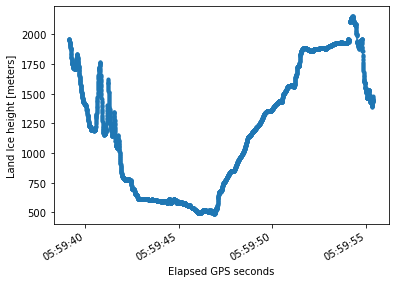

In [6]:
# plot land ice height. notice how xarray decoded the time stamps on the fly, along with other metadata.
ds['h_li'].plot(marker='.');

#### open and plot the first three files

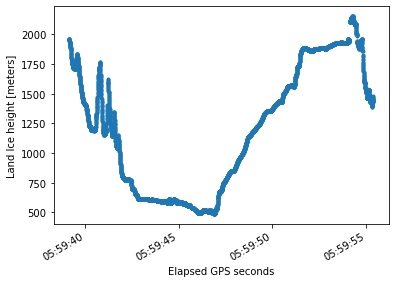

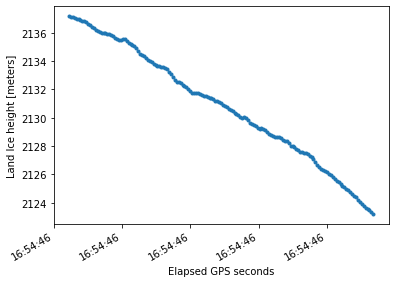

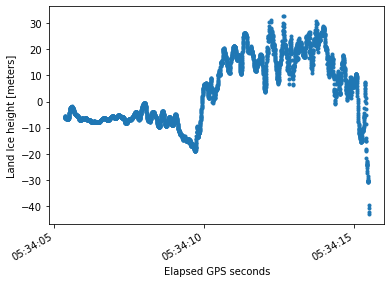

In [7]:
for blob in hf5_files_blobs[0:3]:
    ds = xr.open_dataset(da.open(blob[1]),group='/gt3r/land_ice_segments')
    plt.figure()
    ds['h_li'].plot(marker='.', linestyle='none')

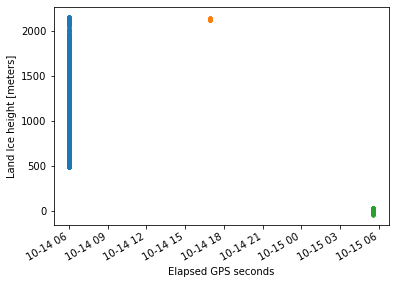

In [8]:
# or on a single plot
for blob in hf5_files_blobs[0:3]:
    ds = xr.open_dataset(da.open(blob[1]),group='/gt3r/land_ice_segments')
#     plt.figure()
    ds['h_li'].plot(marker='.', linestyle='none');

#### use xr.open_mfdataset() to plot the first ten files urls in the list

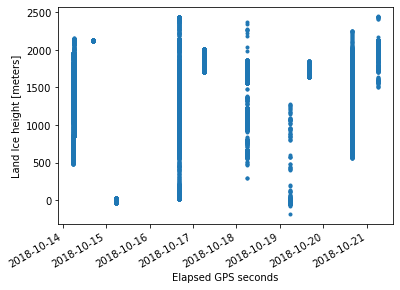

In [9]:
ds = xr.open_mfdataset([da.open(blob[1]) for blob in hf5_files_blobs[0:10]],group='/gt3r/land_ice_segments')
ds['h_li'].plot(marker='.', linestyle='none');

#### Bonus: 
GDAL, unlike the [engines](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) running under the hood of xarray used to open hdf5 files, can read a file directly from url. Here I am pointing GDAL directly at a url for a .tif file hosted on google drive. GDAL knows what to do from there.

In [ ]:
!conda install gdal --yes

In [10]:
from osgeo import gdal

In [11]:
base_url = 'https://drive.google.com/uc?export=download&id='
blob_id = '1GkRzTAFORZXbzUcP9vwCM02h9xTSw6ah'
url = base_url + blob_id
url

'https://drive.google.com/uc?export=download&id=1GkRzTAFORZXbzUcP9vwCM02h9xTSw6ah'

In [12]:
img = gdal.Open(url)
img.ReadAsArray()

array([[  0,   0,   0, ...,   0,   0,   0],
       [152, 149, 161, ...,  73,  70,  64],
       [142, 140, 149, ...,  69,  69,  64],
       ...,
       [ 14,  11,   1, ...,  22,  19,  13],
       [ 11,  17,  11, ...,   4,   7,  13],
       [ 14,  14,   8, ...,   1,  10,  19]], dtype=uint8)

Note that you could still use driveanon here to point to a google drive folder containing tif files, then build the urls and iterate over tif files that way.

In [13]:
tif_file_names, tif_blobs = da.list_blobs('16MX68cYJmwbWZ1lswt0ugQGu6qj7FSH7' ,extension='.tif')

for blob_id in tif_blobs:
    url = base_url + blob_id
    img = gdal.Open(url)
    print(img.ReadAsArray()[0])

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


Xarray engines to open hdf5 files don't seem to have this capability built in yet, which is why we had to use driveanon to stream in the data to xarray. However looks like some folks working on the [h5pyd](https://github.com/HDFGroup/h5pyd) engine are attempting to make this work, which xarray should inherit. You can try out different engines with xarray as follows: `xr.open_dataset(url, engine='h5netcdf')`. I gave this a shot, after install h5pyd (along with testing the other engines), but ran into an error not worth hunting down since driveanon (using requests and io) is likely a similar implementation.